In [1]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

import pymanopt
import pymanopt.manifolds
import pymanopt.solvers
# from pymanopt.solvers import TrustRegions

from numpy.random import default_rng

import networkx as nx

In [2]:
def cost(Y):
    return -1/4 * np.trace(Y @ Y.T @ L)

In [3]:
def hyperplane_rounding(Y, cost, iter=100):
    min_cost = 0
    best_x = None
    d = Y.shape[1]
    rng = default_rng()
    for i in range(iter):
        r = rng.random((d,1))
        r = r / np.linalg.norm(r)
        x = np.sign(Y @ r)
        cost_val = cost(x)
        if cost_val < min_cost:
            min_cost = cost_val
            best_x = x
    return best_x, min_cost

In [4]:
# one iteration of elliptope optimization
def iterate_elliptope(rank, n, L, initial_Y=None):
    print("Current rank: %s"  %(rank))

    manifold = pymanopt.manifolds.Elliptope(n, rank)
    @pymanopt.function.Autograd(manifold)
    def manifold_cost(Y):
        return -1/4 * np.trace(Y @ Y.T @ L)

    problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
    solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
    solution = solver.solve(problem, x=initial_Y)

    return solution, manifold_cost(solution)

In [5]:
def normalize_rows(X):
    # normalize the rows of matrix X
    return X / np.linalg.norm(X, axis=1)[:, np.newaxis]

In [6]:
# reduce rank via eignprojection and row normalization
def eigen_proj(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 1:
        eigen_values, eigen_vectors = np.linalg.eig(X)
        eigen_values = np.real(eigen_values)
        eigen_vectors = np.real(eigen_vectors)
        # sort by eigenvalues, from the largest to the smallest
        idx = eigen_values.argsort()[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:,idx]

        Y_proj = eigen_vectors[:, range(target_rank)] @ np.diag(np.sqrt(eigen_values[range(target_rank)]))
        Y_proj = normalize_rows(Y_proj)
    return Y_proj, target_rank

In [7]:
# reduce rank by optimizing over a manifold
def closest_point(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 2:
        manifold = pymanopt.manifolds.Elliptope(n, target_rank)
        @pymanopt.function.Autograd(manifold)
        def manifold_cost(Y):
            return -np.trace(Y @ Y.T @ X)

        problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
        solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
        Y_proj = solver.solve(problem)

    return Y_proj, target_rank

### Data

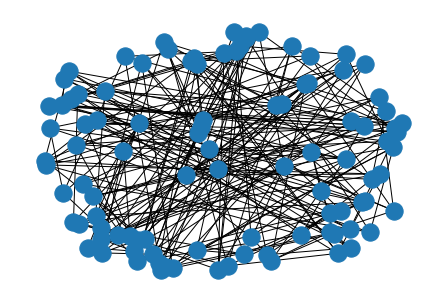

In [8]:
data_path = "../dat/"
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

with open(data_path + graph_file) as inf:
    next(inf, '')   # skip first line
    G = nx.read_weighted_edgelist(inf, nodetype=int, encoding="utf-8")

nx.draw(G.subgraph(range(100)))

In [9]:
n = len(G)
L = nx.laplacian_matrix(G).toarray() * 1.0
opt_sdp_rank = 34  # the optimal solution from the original BM method paper is 33

## Solve SDP relaxation

In [10]:
sdp_solution, sdp_cost = iterate_elliptope(opt_sdp_rank, n, L)

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -7.5534222525329309e-01    2.73498450e+01    
   2         -2.8052004777356533e+01    2.72689023e+01    
   3         -1.3294323126595052e+02    2.55463891e+01    
   4         -3.5902488725716773e+02    1.52121167e+01    
   5         -4.2194899067373780e+02    1.75878821e+01    
   6         -4.6817940121227809e+02    9.20683221e+00    
   7         -4.7968650916303977e+02    9.46456612e+00    
   8         -4.8669028596185564e+02    9.59732066e+00    
   9         -4.9926715732670766e+02    3.84849602e+00    
  10         -5.0294980493459207e+02    6.33598078e+00    
  11         -5.0771489047171190e+02    3.97185496e+00    
  12         -5.0847364551245062e+02    5.61620592e+00    
  13         -5.1094950636352490e+02    3.61962967e+00    
  14         -5.1289833159720354e+02    2.64432810e+00    
  15         -5.140630162

## Manifold iteration

### Eigenprojection + hyperplane rounding

In [11]:
eigen_proj_ranks = []
eigen_proj_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    eigen_proj_ranks += [rank_new]
    eigen_proj_costs += [-cost_val]
    Y_new, rank_new = eigen_proj(solution_new)
eigen_proj_solution, eigen_proj_cost = hyperplane_rounding(solution_new, cost)
eigen_proj_simple_rounding_cost = cost(Y_new)
eigen_proj_ranks += [1, 1]
eigen_proj_costs += [-eigen_proj_cost, -eigen_proj_simple_rounding_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -1.5605738607256709e+00    2.72084586e+01    
   2         -2.8715449614254918e+01    2.71268839e+01    
   3         -1.3305202431531862e+02    2.54135322e+01    
   4         -3.5821612178718726e+02    1.52173157e+01    
   5         -4.2288622029699843e+02    1.75093957e+01    
   6         -4.6761500782011171e+02    9.86873698e+00    
   7         -4.8241553819169405e+02    7.92986571e+00    
   8         -4.9128847333810330e+02    7.00678045e+00    
   9         -4.9889876880287727e+02    4.34885585e+00    
  10         -5.0085971214747485e+02    7.52624652e+00    
  11         -5.0663219955325951e+02    3.77627730e+00    
  12         -5.0924039463535416e+02    3.02842790e+00    
  13         -5.1108421332364031e+02    3.63101976e+00    
  14         -5.1185924861484864e+02    4.68853710e+00    
  15         -5.141309143

### Closest point + hyperplane rounding

In [12]:
closest_point_ranks = []
closest_point_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    closest_point_ranks += [rank_new]
    closest_point_costs += [-cost_val]
    Y_new, rank_new = closest_point(solution_new)
closest_point_solution, closest_point_cost = hyperplane_rounding(solution_new, cost)
closest_point_ranks += [1]
closest_point_costs += [-closest_point_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.9566132402655869e-01    2.73083178e+01    
   2         -2.6664946449704100e+01    2.72379731e+01    
   3         -1.3148612286291564e+02    2.55466164e+01    
   4         -3.5789501518260835e+02    1.52245630e+01    
   5         -4.2324889860928965e+02    1.74406347e+01    
   6         -4.6715608353413978e+02    1.01581539e+01    
   7         -4.8329834131129473e+02    7.27405662e+00    
   8         -4.8885352207837263e+02    9.14688905e+00    
   9         -5.0048017225037444e+02    3.26829748e+00    
  10         -5.0812648092767472e+02    7.43374987e+00    
  11         -5.1483712237827058e+02    2.21457778e+00    
  12         -5.1597335998306312e+02    3.16508185e+00    
  13         -5.1690050933565828e+02    3.10681738e+00    
  14         -5.1804087318435893e+02    2.32670620e+00    
  15         -5.188177344

## Benchmark: hyperplane rounding of SDP solution

In [13]:
_, hyperplane_rounding_cost= hyperplane_rounding(sdp_solution, cost)

### Benchmark: greedy one-exchange

In [14]:
from networkx.algorithms.approximation import maxcut
one_exchange_cost = maxcut.one_exchange(G, weight="weight", initial_cut=None)[0]

## Plots

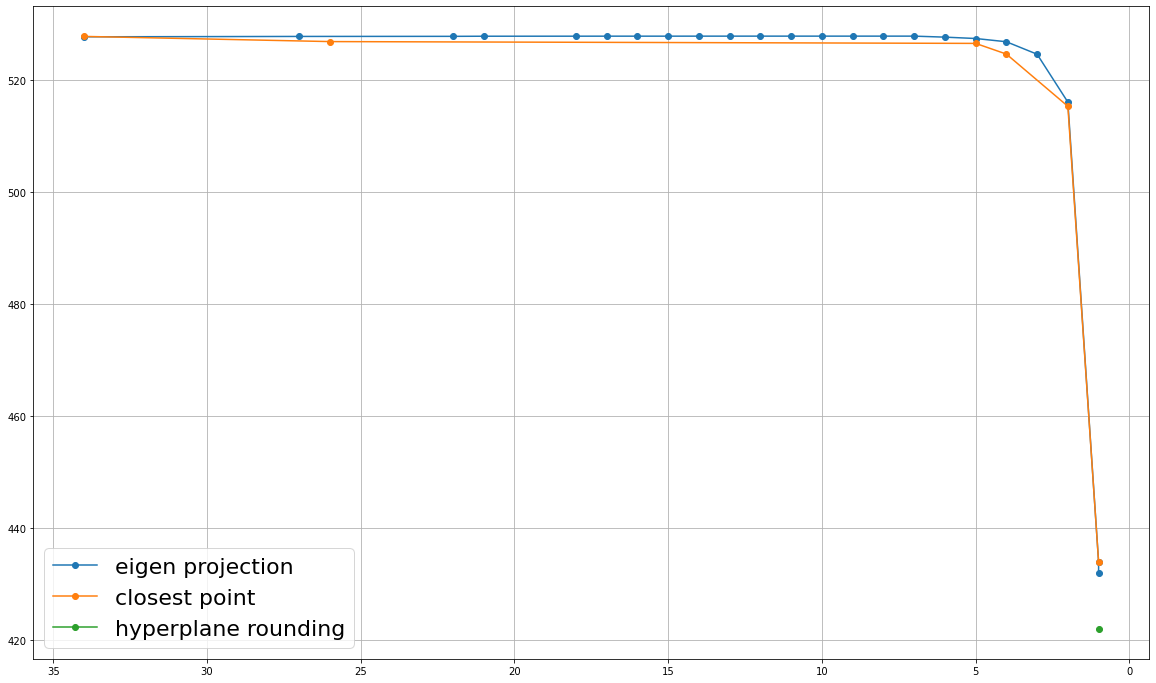

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
ax.invert_xaxis()

plt.plot(eigen_proj_ranks, eigen_proj_costs, label="eigen projection", marker="o")
plt.plot(closest_point_ranks, closest_point_costs, label="closest point", marker="o")

plt.plot([1], [-hyperplane_rounding_cost], label="hyperplane rounding", marker="o")

plt.legend(loc='lower left', fontsize=22)
plt.grid()